In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlays.phase_correction_unified_overlay import phase_correction_unified_overlay
base = phase_correction_unified_overlay('overlays/phase_correction_unified_overlay/unified_overlay.bit')

base.init_rf_clks()

In [17]:
base.ip_dict

{'radio/avgs_config_writer': {'type': 'xilinx.com:hls:passer_config_writer:1.0',
  'mem_id': 's_axi_a',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_A_ADDR_WIDTH': '5',
   'C_S_AXI_A_DATA_WIDTH': '32',
   'Component_Name': 'base_avgs_config_writer_0',
   'clk_period': '3.17',
   'machine': '64',
   'combinational': '0',
   'latency': '1',
   'II': 'x',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_A_BASEADDR': '0xB0000000',
   'C_S_AXI_A_HIGHADDR': '0xB000FFFF',
   'ADDR_WIDTH': '5',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'READ_WRITE_MODE': 'READ_WRITE',
   'FREQ_HZ': '307200000',
   'ID_WIDTH': '0',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_WIDTH': '0',
   'RUSER_WIDTH': '0',
   'BUSER_WIDTH': '0',
   'HAS_BURST': '0',
   'HAS_LOCK': '0',
   'HAS_PROT': '0',
   'HAS_CACHE': '0',
   'HAS_QOS': '0',
   'HAS_REGION': '0',
   'HAS_WSTRB': '1',
   'HAS_BRESP': '1',
   'HAS_RRESP': '1',
   'SUPPORTS_NARROW_BURST': '0',
   'N

In [18]:
# configure to send averages from PL to PS. this is only done once after loading the overlay
base.radio.passers_and_dma.output_passer_config_writer_orig.write(base.radio.passers_and_dma.output_passer_config_writer_orig.register_map.send.address, 0)
base.radio.passers_and_dma.output_passer_config_writer_orig_corrected.write(base.radio.passers_and_dma.output_passer_config_writer_orig_corrected.register_map.send.address, 0)
base.radio.passers_and_dma.output_passer_config_writer_avg.write(base.radio.passers_and_dma.output_passer_config_writer_avg.register_map.send.address, 1)
base.radio.passers_and_dma.output_passer_config_writer_log.write(base.radio.passers_and_dma.output_passer_config_writer_log.register_map.send.address, 1)

In [19]:
# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part
# which are 32 bit long each but python doesnt know the difference. the 4*32 bits are packed into a 128 bit bus
num_samples = int(13852)
num_values = int(num_samples*2)
data_type = np.int32

hardware_avgs = 100
software_traces = 200

data = np.zeros([software_traces, num_values])
buffer_trig = allocate(shape=(num_values,), dtype=data_type)
buffer_log = allocate(shape=(20000*4,), dtype=np.float32)

base.radio.avgs_config_writer.write(base.radio.avgs_config_writer.register_map.send.address, hardware_avgs)

base.radio.passers_and_dma.axi_dma_log.recvchannel.transfer(buffer_log)
base.radio.passers_and_dma.axi_dma_avg.recvchannel.transfer(buffer_trig)
base.radio.input_passer_config_writer.write(base.radio.input_passer_config_writer.register_map.send.address, 1)
a = time.time()
for idx in np.arange(software_traces-1):
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.wait()
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.transfer(buffer_trig)
    data[idx, :] = np.copy(np.array(buffer_trig))
    
base.radio.passers_and_dma.axi_dma_log.recvchannel.wait()
log_data = np.copy(np.array(buffer_log))
print(time.time()-a)    
    
base.radio.passers_and_dma.axi_dma_avg.recvchannel.wait()
data[idx, :] = np.copy(np.array(buffer_trig))



base.radio.input_passer_config_writer.write(base.radio.input_passer_config_writer.register_map.send.address, 0)

data_real = data[:, ::2]
data_imag = data[:, 1::2]
data_compl = data_real + 1j*data_imag

delta_times = log_data[::4]
phases = log_data[1::4]
center_freqs = log_data[2::4]
spacers = log_data[3::4]

#np.save('data/data_iodine_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_compl)
#np.save('data/data_iodine_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces) + 'log_data', log_data

1.0022263526916504


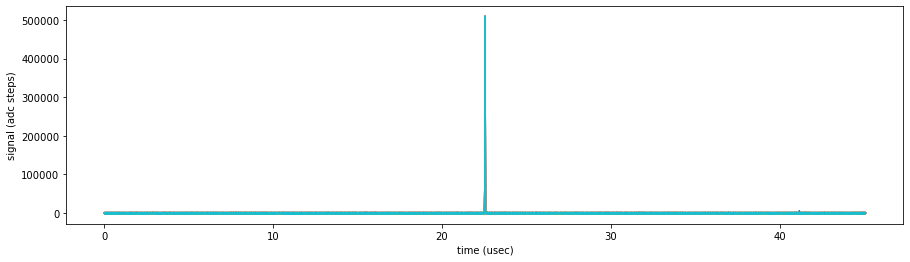

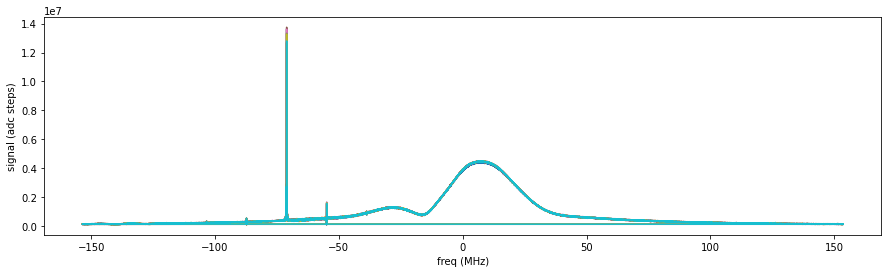

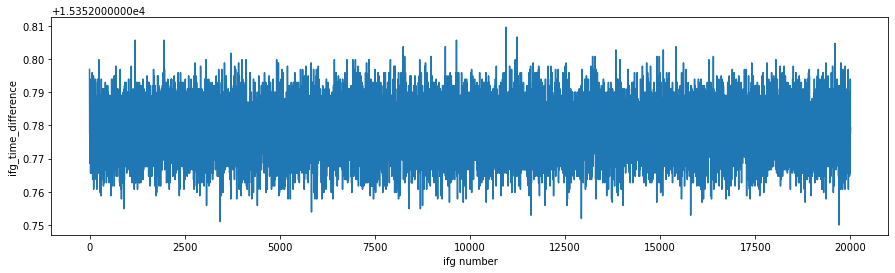

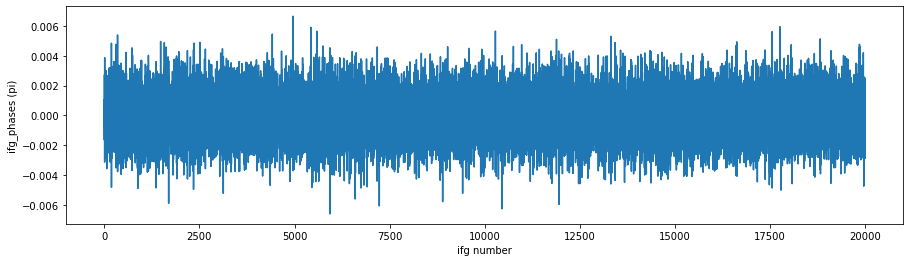

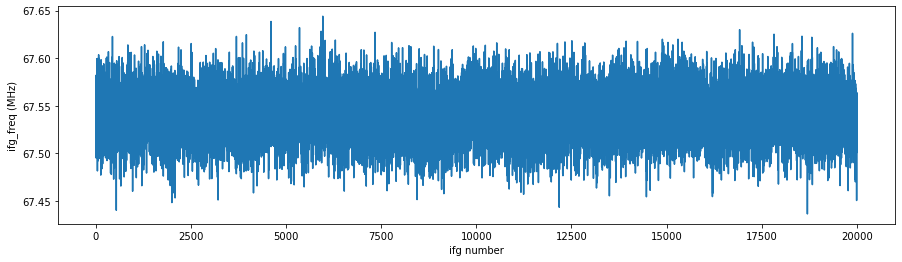

In [20]:
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values/2/sample_frequency, 1/sample_frequency)
freq = np.fft.fftfreq(data_compl.shape[1], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    plt.plot(time_vec*1e6, np.real(data_compl[idx, :]))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    data_fft = np.fft.fft(data_compl[idx, :])
    plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([-50, 50])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(delta_times)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_time_difference')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(np.diff(np.unwrap(phases*np.pi))/np.pi)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_phases (pi)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot((center_freqs*sample_frequency+sample_frequency/2)/1e6)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_freq (MHz)')
plt.show()